In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from meteostat import Point, Daily, Hourly

Load data:

In [2]:
df = pd.read_csv('EPL_2019_2022.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Columns: 107 entries, Div to season
dtypes: float64(82), int64(17), object(8)
memory usage: 953.1+ KB


In [4]:
df.head(5)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season
0,E0,2019-08-09,20:00,Liverpool,Norwich,4,1,1,4,0,...,-2.25,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99,2019-2020
1,E0,2019-08-10,12:30,West Ham,Man City,0,5,0,0,1,...,1.75,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92,2019-2020
2,E0,2019-08-10,15:00,Bournemouth,Sheffield United,1,1,0,0,0,...,-0.50,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92,2019-2020
3,E0,2019-08-10,15:00,Burnley,Southampton,3,0,1,0,0,...,0.00,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02,2019-2020
4,E0,2019-08-10,15:00,Crystal Palace,Everton,0,0,0,0,0,...,0.25,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93,2019-2020


In [5]:
def calculate_average_stats(df, n = 5):
    # Sort the dataframe by date
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Create new columns to store the averages
    df['Home_Avg_FTHG'] = 0
    df['Home_Avg_HS'] = 0
    df['Home_Avg_HST'] = 0
    df['Home_Avg_HF'] = 0
    df['Home_Avg_HC'] = 0
    df['Home_Avg_HY'] = 0
    df['Home_Avg_HR'] = 0

    df['Away_Avg_FTAG'] = 0
    df['Away_Avg_AS'] = 0
    df['Away_Avg_AST'] = 0
    df['Away_Avg_AF'] = 0
    df['Away_Avg_AC'] = 0
    df['Away_Avg_AY'] = 0
    df['Away_Avg_AR'] = 0

    # Iterate through each row to calculate averages
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Get the previous 5 games for the home team
        home_prev_games = df[(df['HomeTeam'] == home_team) & (df['Date'] < row['Date'])].tail(n)

        # Calculate averages for the home team
        df.at[index, 'Home_Avg_FTHG'] = home_prev_games['FTHG'].mean()
        df.at[index, 'Home_Avg_HS'] = home_prev_games['HS'].mean()
        df.at[index, 'Home_Avg_HST'] = home_prev_games['HST'].mean()
        df.at[index, 'Home_Avg_HF'] = home_prev_games['HF'].mean()
        df.at[index, 'Home_Avg_HC'] = home_prev_games['HC'].mean()
        df.at[index, 'Home_Avg_HY'] = home_prev_games['HY'].mean()
        df.at[index, 'Home_Avg_HR'] = home_prev_games['HR'].mean()

        # Get the previous 3 games for the away team
        away_prev_games = df[(df['AwayTeam'] == away_team) & (df['Date'] < row['Date'])].tail(n)

        # Calculate averages for the away team
        df.at[index, 'Away_Avg_FTAG'] = away_prev_games['FTAG'].mean()
        df.at[index, 'Away_Avg_AS'] = away_prev_games['AS'].mean()
        df.at[index, 'Away_Avg_AST'] = away_prev_games['AST'].mean()
        df.at[index, 'Away_Avg_AF'] = away_prev_games['AF'].mean()
        df.at[index, 'Away_Avg_AC'] = away_prev_games['AC'].mean()
        df.at[index, 'Away_Avg_AY'] = away_prev_games['AY'].mean()
        df.at[index, 'Away_Avg_AR'] = away_prev_games['AR'].mean()

    return df

# Assuming 'df' is your original DataFrame
df_generated = calculate_average_stats(df)

In [6]:
df_generated.tail(5)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Home_Avg_HC,Home_Avg_HY,Home_Avg_HR,Away_Avg_FTAG,Away_Avg_AS,Away_Avg_AST,Away_Avg_AF,Away_Avg_AC,Away_Avg_AY,Away_Avg_AR
1132,E0,2022-05-22,16:00,Brighton,West Ham,3,1,1,0,1,...,7.4,1.4,0.0,1.0,8.6,2.8,7.2,4.2,0.8,0.2
1131,E0,2022-05-22,16:00,Brentford,Leeds,1,2,0,0,0,...,5.6,1.2,0.2,1.4,11.2,3.8,13.2,5.6,2.0,0.2
1130,E0,2022-05-22,16:00,Arsenal,Everton,5,1,1,2,1,...,4.6,1.6,0.0,1.0,12.8,3.2,10.8,5.0,2.0,0.2
1133,E0,2022-05-22,16:00,Burnley,Newcastle,1,2,0,0,1,...,5.4,1.8,0.0,0.8,10.4,3.8,11.0,3.4,2.4,0.0
1139,E0,2022-05-22,16:00,Norwich,Tottenham,0,5,0,0,2,...,5.0,0.8,0.0,1.8,11.0,3.6,9.0,4.8,1.8,0.0


In [7]:
def add_rest_columns(df):
    # Sort the dataframe by date
    df = df.sort_values(by='Date')
    
    # Dictionary to store the last game dates for each team
    last_game_dates = {}
    
    # Lists to store the rest days for home and away teams
    home_team_rest = []
    away_team_rest = []
    
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        game_date = row['Date']
        
        # Calculate home team's rest
        home_team_rest.append((game_date - last_game_dates.get(home_team, game_date)).days)
        
        # Calculate away team's rest
        away_team_rest.append((game_date - last_game_dates.get(away_team, game_date)).days)
        
        # Update last game dates for home and away teams
        last_game_dates[home_team] = game_date
        last_game_dates[away_team] = game_date
    
    # Add new columns to the dataframe
    df['Home_Team_Rest'] = home_team_rest
    df['Away_Team_Rest'] = away_team_rest
    
    return df

df_generated = add_rest_columns(df_generated)

In [8]:
df_generated.tail(5)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Home_Avg_HR,Away_Avg_FTAG,Away_Avg_AS,Away_Avg_AST,Away_Avg_AF,Away_Avg_AC,Away_Avg_AY,Away_Avg_AR,Home_Team_Rest,Away_Team_Rest
1136,E0,2022-05-22,16:00,Leicester,Southampton,4,1,1,0,0,...,0.0,0.6,14.6,3.8,7.6,7.4,1.0,0.0,3,5
1137,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,1,1,1,...,0.0,0.6,11.4,2.8,8.8,3.6,1.2,0.0,5,7
1135,E0,2022-05-22,16:00,Crystal Palace,Man United,1,0,1,1,0,...,0.0,0.4,9.6,3.4,10.2,5.0,2.2,0.0,3,15
1134,E0,2022-05-22,16:00,Chelsea,Watford,2,1,1,1,0,...,0.0,0.6,6.8,2.0,11.0,3.4,1.2,0.2,3,7
1139,E0,2022-05-22,16:00,Norwich,Tottenham,0,5,0,0,2,...,0.0,1.8,11.0,3.6,9.0,4.8,1.8,0.0,7,7


In [9]:
df_generated['HomeTeam'].unique()

array(['Liverpool', 'West Ham', 'Bournemouth', 'Burnley',
       'Crystal Palace', 'Watford', 'Tottenham', 'Leicester', 'Newcastle',
       'Man United', 'Arsenal', 'Aston Villa', 'Man City', 'Brighton',
       'Norwich', 'Southampton', 'Everton', 'Sheffield United', 'Chelsea',
       'Wolves', 'Fulham', 'West Brom', 'Leeds', 'Brentford'],
      dtype=object)

In [10]:
team_to_stadium = {
    'Liverpool': 'Anfield',
    'West Ham': 'London Stadium',
    'Bournemouth': 'Vitality Stadium',
    'Burnley': 'Turf Moor',
    'Crystal Palace': 'Selhurst Park',
    'Watford': 'Vicarage Road',
    'Tottenham': 'Tottenham Hotspur Stadium',
    'Leicester': 'King Power Stadium',
    'Newcastle': 'St. James\' Park',
    'Man United': 'Old Trafford',
    'Arsenal': 'Emirates Stadium',
    'Aston Villa': 'Villa Park',
    'Man City': 'Etihad Stadium',
    'Brighton': 'Amex Stadium',
    'Norwich': 'Carrow Road',
    'Southampton': 'St Mary\'s Stadium',
    'Everton': 'Goodison Park',
    'Sheffield United': 'Bramall Lane',
    'Chelsea': 'Stamford Bridge',
    'Wolves': 'Molineux Stadium',
    'Fulham': 'Craven Cottage',
    'West Brom': 'The Hawthorns',
    'Leeds': 'Elland Road',
    'Brentford': 'Brentford Community Stadium'
}

In [11]:
stadium_to_coords = {
    'Anfield': (53.4308, -2.9608),
    'London Stadium': (51.5387, -0.0166),
    'Vitality Stadium': (50.7352, -1.8383),
    'Turf Moor': (53.7890, -2.2302),
    'Selhurst Park': (51.3983, -0.0855),
    'Vicarage Road': (51.6498, -0.4017),
    'Tottenham Hotspur Stadium': (51.6043, -0.0674),
    'King Power Stadium': (52.6204, -1.1422),
    'St. James\' Park': (54.9756, -1.6217),
    'Old Trafford': (53.4631, -2.2913),
    'Emirates Stadium': (51.5549, -0.1084),
    'Villa Park': (52.5092, -1.8849),
    'Etihad Stadium': (53.4831, -2.2003),
    'Amex Stadium': (50.8616, -0.0837),
    'Carrow Road': (52.6221, 1.3086),
    'St Mary\'s Stadium': (50.9058, -1.3911),
    'Goodison Park': (53.4388, -2.9663),
    'Bramall Lane': (53.3703, -1.4714),
    'Stamford Bridge': (51.4817, -0.1910),
    'Molineux Stadium': (52.5902, -2.1304),
    'Craven Cottage': (51.4753, -0.2216),
    'The Hawthorns': (52.5091, -1.9639),
    'Elland Road': (53.7776, -1.5724),
    'Brentford Community Stadium': (51.4908, -0.2887)
}

In [12]:
def add_stadium_lat_long(df):
    """Add stadium name and coordinates to the dataframe based on HomeTeam."""
    df['Stadium'] = df['HomeTeam'].map(team_to_stadium).fillna('Unknown Stadium')
    df['Longitude'] = df['Stadium'].map(lambda x: stadium_to_coords.get(x, (None, None))[1])
    df['Latitude'] = df['Stadium'].map(lambda x: stadium_to_coords.get(x, (None, None))[0])
    return df

In [13]:
df_generated = add_stadium_lat_long(df_generated)

In [14]:
def round_time_to_nearest_hour(time):
    """Rounds a datetime object to the nearest hour."""
    if time.minute >= 30:
        time = time + timedelta(minutes=(60 - time.minute))
    else:
        time = time - timedelta(minutes=time.minute)
    return time.replace(second=0, microsecond=0)

def add_weather_data(df):
    """Fetches hourly weather data for specified coordinates, date, and time using Meteostat API
    and adds the data to the input DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns ['Latitude', 'Longitude', 'Date', 'Time']
    
    Returns:
    pd.DataFrame: Input DataFrame with additional columns ['Temperature', 'WindDirection', 'Precipitation', 'WindSpeed', 'ConditionCode']
    """
    weather_data_list = []

    for index, row in df.iterrows():
        latitude = row['Latitude']
        longitude = row['Longitude']
        date_str = row['Date'].strftime('%Y/%m/%d')
        time_str = row['Time']

        datetime_str = f"{date_str} {time_str}"
        date_time = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M')

        rounded_time = round_time_to_nearest_hour(date_time)

        # Define the location and time period
        location = Point(latitude, longitude)
        start = rounded_time
        end = rounded_time

        # Get hourly data
        data = Hourly(location, start, end)
        data = data.fetch()

        if not data.empty:
            weather_info = {
                'Temperature': data.iloc[0]['temp'],
                'Humidity': data.iloc[0]['rhum'],
                'WindDirection': data.iloc[0]['wdir'],
                'Precipitation': data.iloc[0]['prcp'],
                'WindSpeed': data.iloc[0]['wspd'],
                'WeatherCode': data.iloc[0]['coco'],
            }
        else:
            weather_info = {'Temperature': None, 'Humidity': None, 'WindDirection': None, 'Precipitation': None, 'WindSpeed': None, 'WeatherCode': None}

        weather_data_list.append(weather_info)

    weather_df = pd.DataFrame(weather_data_list)
    
    # Add the new weather data columns to the original DataFrame
    df = pd.concat([df, weather_df], axis=1)
    
    return df

In [15]:
df_generated = add_weather_data(df_generated)

In [24]:
df_generated.to_csv('EPL_2019_2022_w_weather.csv', index=False)


In [18]:
df_misss_weather = df_generated[df_generated['Temperature'].isna()].drop(['Temperature','Humidity','WindDirection','Precipitation','WindSpeed','WeatherCode'], axis= 1)

In [50]:
df_misss_weather['HomeTeam'].value_counts()

Burnley             41
Sheffield United    26
Crystal Palace       5
Leicester            3
West Brom            3
Wolves               2
Chelsea              2
Brighton             2
Newcastle            2
Everton              2
Arsenal              1
Liverpool            1
Man United           1
Tottenham            1
Southampton          1
Bournemouth          1
Aston Villa          1
Brentford            1
Name: HomeTeam, dtype: int64

In [52]:
df_misss_weather[df_misss_weather['HomeTeam'] == 'Burnley']


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Away_Avg_AST,Away_Avg_AF,Away_Avg_AC,Away_Avg_AY,Away_Avg_AR,Home_Team_Rest,Away_Team_Rest,Stadium,Longitude,Latitude
3,E0,2019-08-10,15:00,Burnley,Southampton,3,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,0,0,Turf Moor,-2.2302,53.789
37,E0,2019-08-31,17:30,Burnley,Liverpool,0,3,0,0,2,...,6.0,6.0,9.0,1.0,0.0,6,7,Turf Moor,-2.2302,53.789
52,E0,2019-09-21,15:00,Burnley,Norwich,2,0,1,2,0,...,4.0,9.5,2.0,1.5,0.0,7,7,Turf Moor,-2.2302,53.789
95,E0,2019-10-26,17:30,Burnley,Chelsea,2,4,0,0,2,...,7.0,12.0,5.5,2.0,0.0,7,7,Turf Moor,-2.2302,53.789
112,E0,2019-11-09,15:00,Burnley,West Ham,3,0,1,2,0,...,4.8,11.2,5.0,1.4,0.2,7,7,Turf Moor,-2.2302,53.789
141,E0,2019-12-03,20:15,Burnley,Man City,1,4,0,0,1,...,7.8,7.2,9.8,1.6,0.0,3,3,Turf Moor,-2.2302,53.789
161,E0,2019-12-14,15:00,Burnley,Newcastle,1,0,1,0,0,...,3.6,8.6,2.0,0.8,0.2,7,6,Turf Moor,-2.2302,53.789
195,E0,2019-12-28,19:45,Burnley,Man United,0,2,0,0,1,...,7.0,10.6,6.2,2.0,0.0,2,2,Turf Moor,-2.2302,53.789
200,E0,2020-01-01,12:30,Burnley,Aston Villa,1,2,0,0,2,...,2.4,8.8,4.4,1.6,0.0,4,4,Turf Moor,-2.2302,53.789
227,E0,2020-01-19,14:00,Burnley,Leicester,2,1,1,0,1,...,7.4,8.2,4.6,1.2,0.0,8,8,Turf Moor,-2.2302,53.789


In [56]:
import requests
import time

# Sample API key (replace with your own)
API_KEY = 'bc067b9f91e829eae4aa92b4f319acd3'
BASE_URL = 'https://api.openweathermap.org/data/3.0/onecall/timemachine'

# Function to get weather data for a specific location and date
def get_weather(lat, lon, dt):
    params = {
        'lat': lat,
        'lon': lon,
        'dt': dt,
        'appid': API_KEY,
        'units': 'metric'
    }
    response = requests.get(BASE_URL, params=params)
    return response.json()


# Assuming the date is in the format 'yyyy-mm-dd' and time is 'hh:mm'
df_misss_weather['datetime'] = pd.to_datetime(df_misss_weather['Date'].dt.strftime('%Y-%m-%d') + ' ' + df_misss_weather['Time'])

# Convert the 'datetime' to a Unix timestamp
df_misss_weather['timestamp'] = df_misss_weather['datetime'].apply(lambda x: int(x.timestamp()))

weather_data = []

for index, row in df_misss_weather.iterrows():

    lat = row['Latitude']
    lon = row['Longitude']
    timestamp = row['timestamp']
    weather = get_weather(lat, lon, timestamp)
    weather_data.append(weather)


df_misss_weather['Weather'] = weather_data

# Save the updated DataFrame with weather data to a new CSV file
df_misss_weather.to_csv('EPL_with_weather.csv', index=False)

In [59]:
df_misss_weather['Weather'].iloc[0,]

{'cod': 401,
 'message': 'Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.'}

Apply classifier:

In [62]:
print(df_generated.columns)

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'Home_Avg_HR', 'Away_Avg_FTAG', 'Away_Avg_AS', 'Away_Avg_AST',
       'Away_Avg_AF', 'Away_Avg_AC', 'Away_Avg_AY', 'Away_Avg_AR',
       'Home_Team_Rest', 'Away_Team_Rest'],
      dtype='object', length=123)


In [63]:
selected_features = ['Home_Avg_FTHG',
                     'Home_Avg_HS',
                     'Home_Avg_HST',
                     'Home_Avg_HF',
                     'Home_Avg_HC',
                     'Home_Avg_HY',
                     'Home_Avg_HR',
                     'Away_Avg_FTAG',
                     'Away_Avg_AS',
                     'Away_Avg_AST',
                     'Away_Avg_AF',
                     'Away_Avg_AC',
                     'Away_Avg_AY',
                     'Away_Avg_AR']


In [64]:
X_train = df_generated[df_generated['season'] != '2021-2022'][selected_features]
y_train = df_generated[df_generated['season'] != '2021-2022']['FTR']
X_test = df_generated[df_generated['season'] == '2021-2022'][selected_features]
y_test = df_generated[df_generated['season'] == '2021-2022']['FTR']

In [65]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((735, 14), (735,), (373, 14), (373,))

### Logistic Regression:

In [66]:
model = LogisticRegression(max_iter=1000, C=0.001, tol=0.000001, class_weight='balanced')

In [67]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

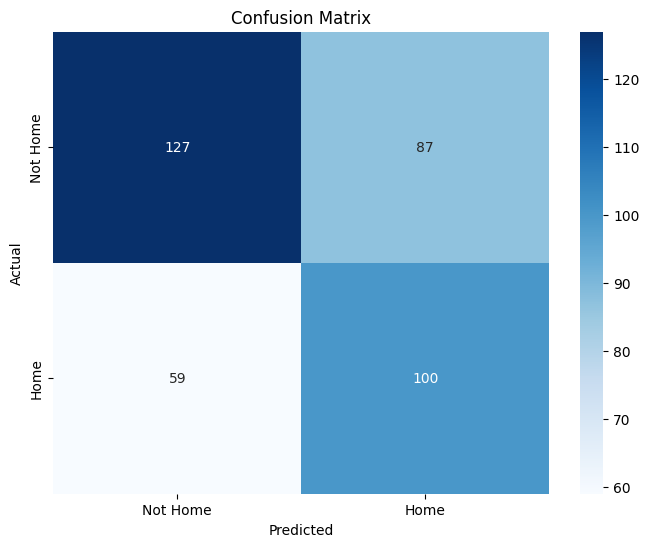

Accuracy: 0.6085790884718498
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.59      0.64       214
           1       0.53      0.63      0.58       159

    accuracy                           0.61       373
   macro avg       0.61      0.61      0.61       373
weighted avg       0.62      0.61      0.61       373



In [68]:
 # Display confusion matrix using seaborn
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

### Apply XGBoost:

In [69]:
model = xgb.XGBClassifier(objective='reg:logistic',
                            eval_metric=['error', 'auc'], learning_rate=0.1, gamma=0, max_depth=8, n_estimators=300)

In [70]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

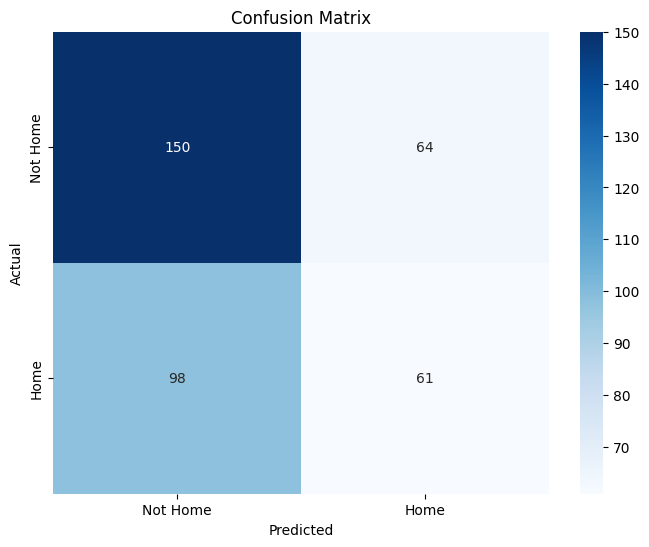

Accuracy: 0.5656836461126006
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.70      0.65       214
           1       0.49      0.38      0.43       159

    accuracy                           0.57       373
   macro avg       0.55      0.54      0.54       373
weighted avg       0.56      0.57      0.56       373



In [71]:
# Display confusion matrix using seaborn
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)